In [1]:
# Installing Libraries
!pip install qiskit pylatexenc --quiet
!pip install qiskit.ignis --quiet

In [2]:
# Importing Libraries
from qiskit import *
from qiskit.tools.monitor import  job_monitor
from qiskit.tools.visualization import plot_state_qsphere
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex

import numpy as np
from qiskit.extensions import Initialize
from qiskit.ignis.verification import marginal_counts
from qiskit.quantum_info import random_statevector

C:\Users\alamg\AppData\Local\Temp/ipykernel_11676/206650140.py:9: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.verification import marginal_counts


## Design Circuit

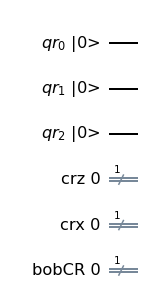

In [3]:
qr= QuantumRegister(3, name="qr")

crz = ClassicalRegister(1, name='crz')
crx = ClassicalRegister(1, name='crx')
bobCR = ClassicalRegister(1, name='bobCR')

teleportation_circuit = QuantumCircuit(qr, crz, crx, bobCR)

teleportation_circuit.draw(initial_state = True, output='mpl')

<IPython.core.display.Latex object>

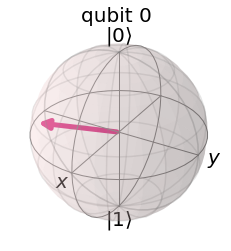

In [4]:
#Create a random state
psi = random_statevector(2)

display(array_to_latex(psi))

init_gate = Initialize(psi)   # Take a state as input and return a gate

init_gate.label = 'psi'

plot_bloch_multivector(psi)

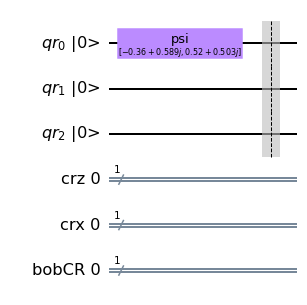

In [5]:
# Assign to Alice --> at 0
teleportation_circuit.append(init_gate,[0])
teleportation_circuit.barrier()
teleportation_circuit.draw(initial_state=True, output='mpl')

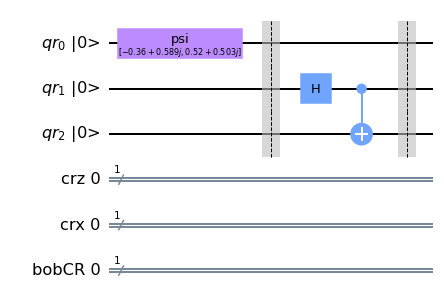

In [6]:
# Entangled Pair between 1 and 2
teleportation_circuit.h(1)
teleportation_circuit.cx(1,2)
teleportation_circuit.barrier()
teleportation_circuit.draw(initial_state=True, output='mpl')

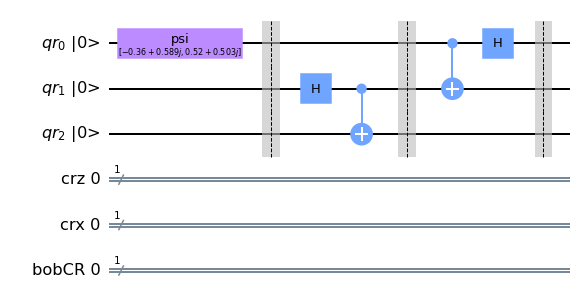

In [7]:
# Alice performs some operations to her qubit --> at 0
teleportation_circuit.cx(0,1)
teleportation_circuit.h(0)
teleportation_circuit.barrier()
teleportation_circuit.draw(initial_state=True, output='mpl')

In [8]:
# Create a  copy of the circuit
import copy
second_teleportation_circuit= copy.deepcopy(teleportation_circuit)

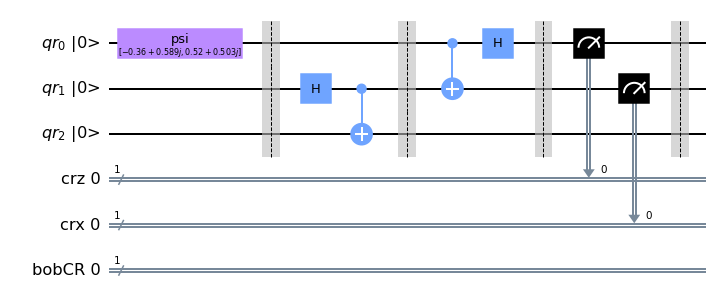

In [9]:
# Alice applice measurement
teleportation_circuit.measure(0,crz)
teleportation_circuit.measure(1,crx)
teleportation_circuit.barrier()
teleportation_circuit.draw(initial_state=True, output='mpl')

#### Convention for `crz` and `crx`
- `00` --> Do Nothing
- `01` --> Apply X gate
- `10` --> Apply Z gate
- `11` --> Apply both X and Z gate

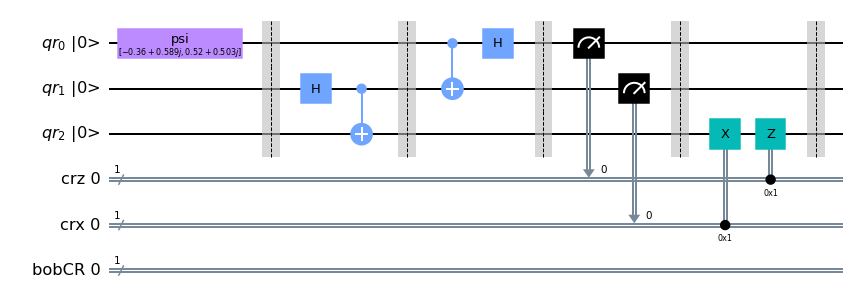

In [10]:
teleportation_circuit.x(2).c_if(crx,1)   # Apply X at 2 if crx = 1
teleportation_circuit.z(2).c_if(crz,1)   # Apply Z at 2 if crz = 1
teleportation_circuit.barrier()
teleportation_circuit.draw(initial_state=True, output='mpl')

In [11]:
# # Run on Simulator
# simulator = Aer.get_backend('aer_simulator')     # Select Simulator
# teleportation_circuit.save_statevector()                       # Save StateVector
# qobj = assemble(teleportation_circuit)                         # Assemble
# job = simulator.run(teleportation_circuit)                     # run the simulation
# job_monitor(job)                                 # Monitor Job
# result = job.result()                            # Get Result

# # View State vector output
# print("printing StateVector")
# final_state = result.get_statevector()     # Get StateVector    
# plot_bloch_multivector(final_state)        # Plot statevector

#### Another way to check the output

Before randomly initalized, the state of the first bit was `0`. As the gates are Reversible, so the reverse of the randomly initialized bit should be `0`. 
So, if the reverse of the output of `bit 2` become `0`, the teleporation was successful.

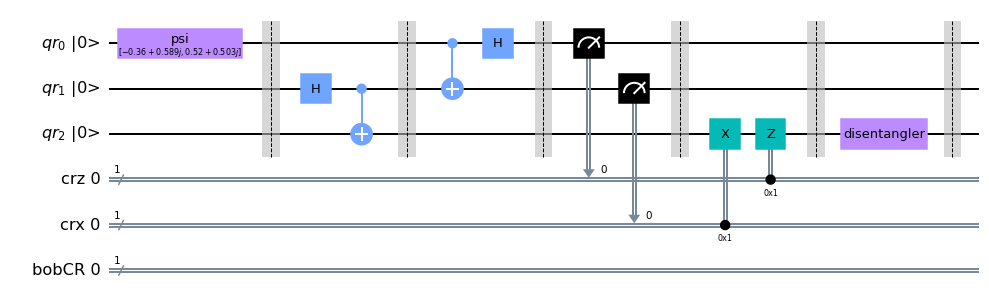

In [12]:
# Reversing step
inverse_init_gate = init_gate.gates_to_uncompute()
teleportation_circuit.append(inverse_init_gate,[2])
teleportation_circuit.barrier()
teleportation_circuit.draw(initial_state=True, output='mpl')

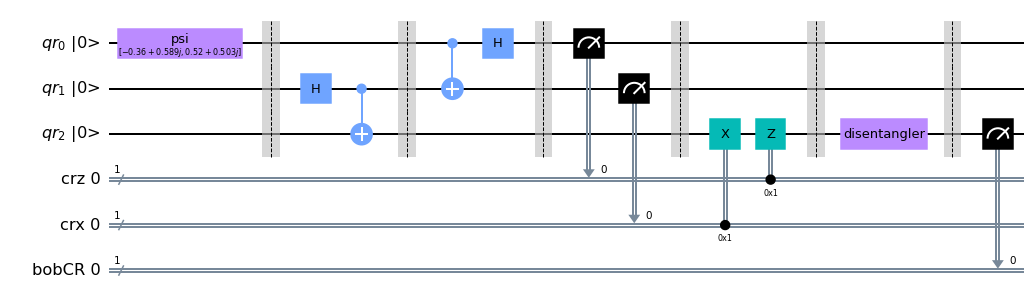

In [13]:
# Measure after reversing
teleportation_circuit.measure(2, bobCR)
teleportation_circuit.draw(initial_state=True, output='mpl')

Job Status: job has successfully run


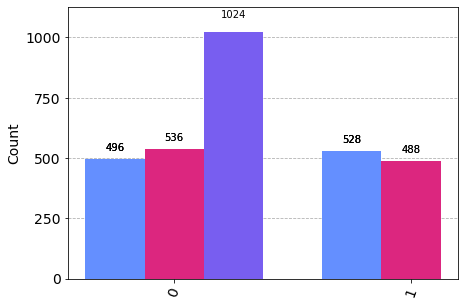

In [14]:
# Run on Simulator
simulator = Aer.get_backend('aer_simulator')     # Select Simulator

# Extra step
t = transpile(teleportation_circuit, simulator)

t.save_statevector()                       # Save StateVector
qobj = assemble(t)                         # Assemble
job = simulator.run(qobj)                     # run the simulation
job_monitor(job)                                 # Monitor Job
result = job.result()                            # Get Result

# Simulated counts output
counts = result.get_counts()       # Get counts

# To plot all the qubits at a time
qubit_counts = [marginal_counts(counts, [qubit]) for qubit in range(3)]
plot_histogram(qubit_counts)             # plot counts

## Operation without Classical Resistor for Run in a Real Device

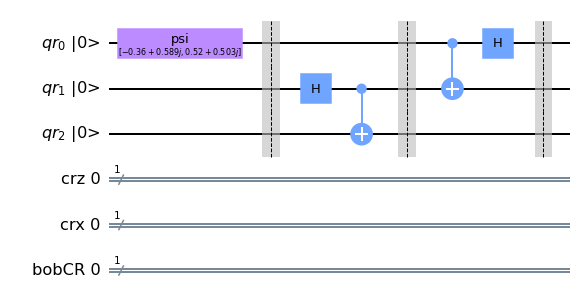

In [15]:
second_teleportation_circuit.draw(initial_state=True, output='mpl')

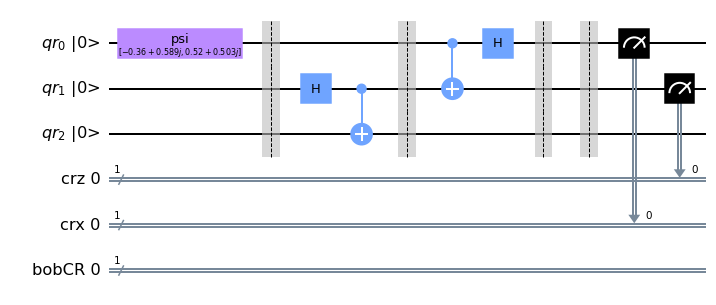

In [16]:
second_teleportation_circuit.barrier()

second_teleportation_circuit.measure(0, crx)
second_teleportation_circuit.measure(1,crz)

second_teleportation_circuit.draw(initial_state=True, output='mpl')

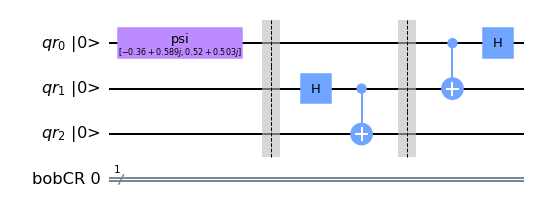

In [17]:
# Removing the resistors
second_teleportation_circuit.remove_final_measurements(inplace=True)
second_teleportation_circuit.draw(initial_state=True, output='mpl')

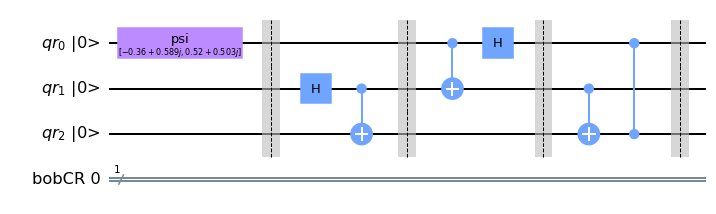

In [18]:
# Applying gate without measuring
second_teleportation_circuit.barrier()
second_teleportation_circuit.cx(1,2)
second_teleportation_circuit.cz(0,2)
second_teleportation_circuit.barrier()
second_teleportation_circuit.draw(initial_state=True, output='mpl')

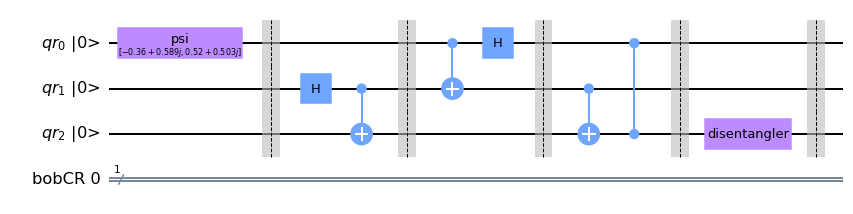

In [19]:
second_teleportation_circuit.append(inverse_init_gate,[2])
second_teleportation_circuit.barrier()
second_teleportation_circuit.draw(initial_state=True, output='mpl')

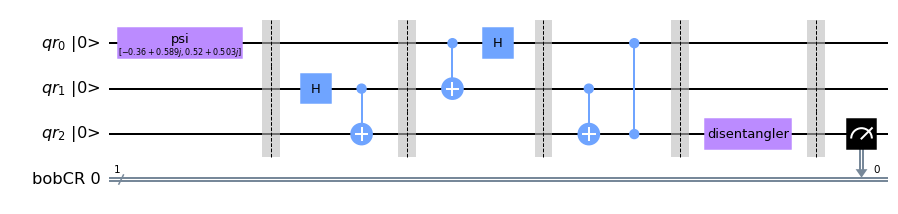

In [20]:
second_teleportation_circuit.measure(2, bobCR)
second_teleportation_circuit.draw(initial_state=True, output='mpl')

## Run on a Real Device

In [21]:
from qiskit import IBMQ
IBMQ.save_account('ba2a4becb31a350eacf6fbb7dccdea98bf9863b70c28f080fe1def15eb592ddbffc35f9367685cb1d261499eb971224d93955a1ff6e720da1af281d6759807a8')

IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')

# get the least-busy backend at IBM and run the quantum circuit there
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor

backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 3 and
                                   not b.configuration().simulator and b.status().operational==True))      # Change the number of bits

t_qc = transpile(second_teleportation_circuit, backend, optimization_level=3)  # Chnage Circuit name if necessary
job = backend.run(t_qc)
job_monitor(job)  # displays job status under cell

configrc.store_credentials:WARNING:2022-11-05 15:26:13,179: Credentials already present. Set overwrite=True to overwrite.


Job Status: job has successfully run


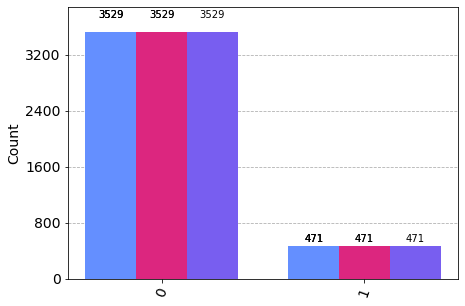

In [22]:
#View jobob results
result = job.result()                            # Get Result
counts = result.get_counts()       # Get counts

# To plot all the qubits at a time
qubit_counts = [marginal_counts(counts, [qubit]) for qubit in range(3)]

plot_histogram(qubit_counts)             # plot counts